In [2]:
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Input, Flatten

import time
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import cv2

BATCH_SIZE = 256  # Big enough to measure an F1-score
# Adapt preprocessing and prefetching dynamically
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 8192


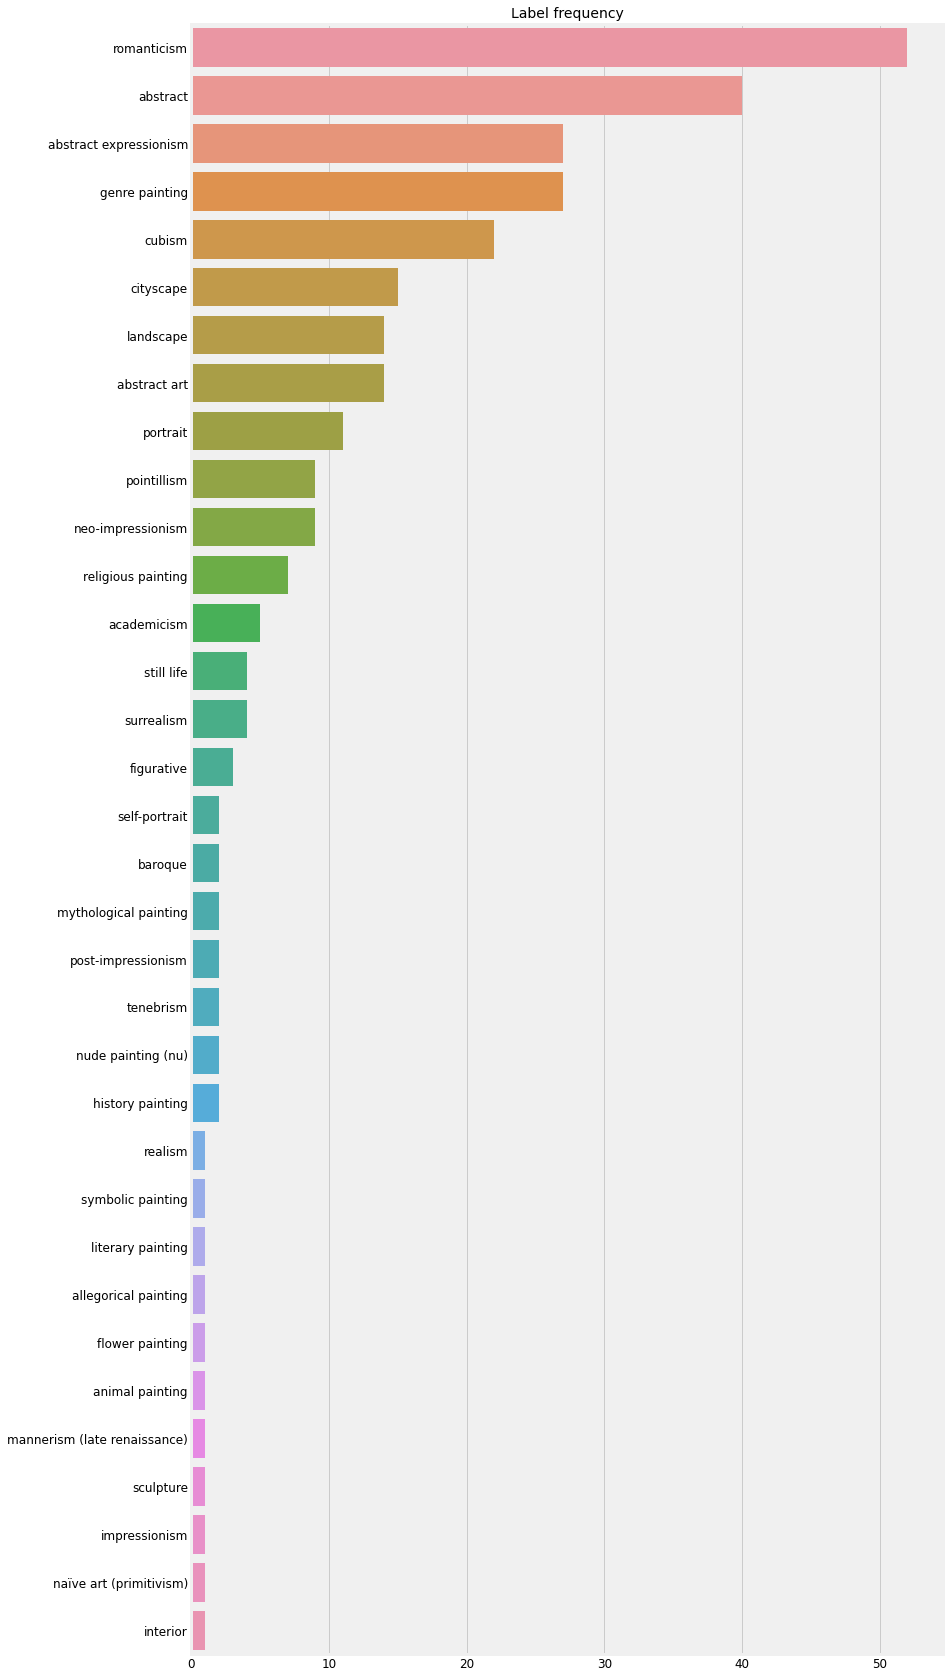

In [3]:
dir_path = './database_test'

file_list = os.listdir(dir_path)
ID = []
Labels = []

for file_name in file_list:
    label_list = file_name.split('+')
    if (label_list[0] == ''):
        continue
    ID.append(label_list[0])
    del label_list[0]
    # .jpg 제거
    label_list.pop()

    valid_label_list = []
    for label in label_list:
        label = label.lower()
        labels = label.split(', ')
        valid_label_list.extend(labels)

    while True:
        try:
            valid_label_list.remove('')
        except ValueError:
            break
    
    Labels.append(valid_label_list)

artworks = pd.DataFrame({"ID": ID, "Labels": Labels, "File": file_list})
artworks.dropna()

# Get label frequencies in descending order
label_freq = artworks['Labels'].apply(lambda s: [x for x in s]).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12, 30))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [4]:
# Create a list of rare labels
# rare = list(label_freq[label_freq < 50].index)
rare = list(label_freq[label_freq < 5].index)
print("Number of used labels:", len(label_freq) - len(rare))
print("Number of ignored labels:", len(rare))
label_number = len(label_freq) - len(rare)

artworks['Labels'] = artworks['Labels'].apply(
    lambda s: [x for x in s if x not in rare])
artworks['Labels'] = artworks['Labels'].apply(lambda s: s if len(s) != 0 else np.nan)

artworks.dropna(inplace=True)

Number of used labels: 13
Number of ignored labels: 21


In [19]:
from sklearn.model_selection import train_test_split
# 파일 경로 및 label 집합으로 train data와 valid data parsing
X_train, X_val, y_train, y_val = train_test_split(artworks['File'], artworks['Labels'], test_size= 0.1, random_state = 23)

X_train = [str(f) for f in X_train]
X_val = [str(f) for f in X_val]


In [20]:
# MultiLabelBinarizer로 다중 label 이진화
mlb = MultiLabelBinarizer()
mlb.fit(artworks['Labels'])

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

y_train = mlb.transform(y_train)
mlb.fit(y_val)
y_val = mlb.transform(y_val)


0. abstract
1. abstract art
2. abstract expressionism
3. academicism
4. cityscape
5. cubism
6. genre painting
7. landscape
8. neo-impressionism
9. pointillism
10. portrait
11. religious painting
12. romanticism


In [21]:
# Print example of movie posters and their binary targets
for i in range(3):
    print(X_train[i], y_train[i])
# print(X_train[55])

100047+genre painting+Cubism+.jpg [0 0 0 0 0 1 1 0 0 0 0 0 0]
100107+genre painting+Romanticism+.jpg [0 0 0 0 0 0 1 0 0 0 0 0 1]
100005+abstract+Abstract Art+.jpg [1 1 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
IMG_SIZE = 224  # Specify height and width of image to match the input format of the model
CHANNELS = 3  # Keep RGB color channels to match the input format of the model

def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label


In [7]:
def create_dataset(filenames, labels, is_training=True):
    # print(filenames)
    # print(labels)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    dataset = dataset.cache()
    dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset.batch(BATCH_SIZE)
    dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [11]:
import numpy as np

dataset_train = create_dataset(X_train, y_train)
dataset_val = create_dataset(X_val, y_val)

for f, l in dataset_train.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc1 in position 191: invalid start byte

In [ ]:
import tensorflow_hub as hub

feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

dataset에 대한 전처리함수 parse_function과 여러 샘플에 대한 병렬 적용을 위한 num_parrallel_calls
dataset.cahce는 데이터 셋을 메모리 또는로컬 저장소에 캐시
dataset.prefetch는 전처리와 훈련스텝의 모델실행을 오버랩

In [17]:
# dataset_train = create_dataset(X_train, y_train)
# dataset_val = create_dataset(X_val, y_val)
# print(dataset_train.shape)
# def create_dataset(X):
#     images = []
#     IMG_SIZE = 224

#     for idx, filename in enumerate(X):
#         image_read = cv2.imread(os.path.join(dir_path, filename))
#         # print(image_read)
#         image_resized = cv2.resize(image_read, (IMG_SIZE, IMG_SIZE))
#         images.append(image_resized)

#     train = np.array(images)

#     return np.array(train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# X_train = create_dataset(X_train)
# y_train = np.expand_dims(y_train, axis = 1)
# X_val = create_dataset(X_val)
# y_val = np.expand_dims(y_val, axis = 1)

# train_generator = ImageDataGenerator(rescale=1/255.0)
# train_dataset = train_generator.flow(X_train, y_train, batch_size=BATCH_SIZE)
# valid_dataset = train_generator.flow(X_val, y_val, batch_size=BATCH_SIZE)


In [18]:
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
print(input_tensor)
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
    
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x

def ResNet50():
    x = conv1_layer(input_tensor)
    x = conv2_layer(x)
    x = conv3_layer(x)
    x = conv4_layer(x)
    x = conv5_layer(x)

    x = GlobalAveragePooling2D()(x)
    output_tensor = Dense(label_number, activation='sigmoid')(x)
    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input'), name='input', description="created by layer 'input'")


In [19]:
model = ResNet50()
LR = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.metrics.binary_crossentropy,
              metrics=['accuracy'])
model.summary()
start = time.time()
print(train)
history = model.fit(train_dataset, epochs=30, validation_data=valid_dataset)
print('\nTraining took {}'.format(print(time.time()-start)))


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv2d_106 (Conv2D)            (None, 112, 112, 64  9472        ['zero_padding2d_4[0][0]']       
                                )                                                           

InvalidArgumentError: Graph execution error:

Detected at node 'binary_crossentropy/remove_squeezable_dimensions/Squeeze' defined at (most recent call last):
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\이성준\AppData\Local\Temp\ipykernel_25424\2404337516.py", line 9, in <cell line: 9>
      history = model.fit(train_dataset, epochs=30, validation_data=valid_dataset)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 265, in call
      y_pred, y_true = losses_utils.squeeze_or_expand_dimensions(
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\losses_utils.py", line 200, in squeeze_or_expand_dimensions
      y_true, y_pred = remove_squeezable_dimensions(y_true, y_pred)
    File "c:\Users\이성준\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\losses_utils.py", line 139, in remove_squeezable_dimensions
      labels = tf.squeeze(labels, [-1])
Node: 'binary_crossentropy/remove_squeezable_dimensions/Squeeze'
Can not squeeze dim[2], expected a dimension of 1, got 13
	 [[{{node binary_crossentropy/remove_squeezable_dimensions/Squeeze}}]] [Op:__inference_train_function_30024]